# Machine Learning

In [135]:
import matplotlib.pyplot as plt
import pandas as pd

train = pd.read_csv('MLUnige2023_subscriptions_train.csv')
test = pd.read_csv('MLUnige2023_subscriptions_test.csv')

In [136]:
train.head()

,Id,age,job,marital,education,device,day,month,time_spent,banner_views,banner_views_old,days_elapsed_old,outcome_old,X1,X2,X3,X4,subscription
0,0,28,freelance,married,grad_school,smartphone,4,2,26.80,3,4,196,failure,0,0,1,0.072803,1
1,1,48,industrial_worker,married,university,smartphone,30,4,13.05,1,1,79,success,0,0,0,0.075454,1
2,2,27,teacher,married,university,smartphone,14,7,8.10,3,0,-1,na,0,1,1,0.068110,0
3,3,44,unemployed,divorced,university,smartphone,13,5,7.10,2,1,369,other,0,0,1,0.091942,0
4,4,29,manager,single,grad_school,smartphone,26,4,15.90,2,2,143,success,0,0,0,0.085922,1


In [137]:
descr = train.describe()
descr

,Id,age,day,month,time_spent,banner_views,banner_views_old,days_elapsed_old,X1,X2,X3,X4,subscription
count,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000
mean,4475.500000,41.201743,15.663762,6.207328,17.130306,2.540550,0.759160,49.403262,0.141086,0.013963,0.496984,0.086603,0.416443
std,2584.364138,11.638321,8.379622,2.509444,16.902741,2.824065,2.099277,107.365840,0.348129,0.117345,0.500019,0.030253,0.492996
min,0.000000,18.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2237.750000,32.000000,8.000000,5.000000,6.100000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.073891,0.000000
50%,4475.500000,39.000000,16.000000,6.000000,11.450000,2.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.077661,0.000000
75%,6713.250000,49.000000,21.000000,8.000000,22.500000,3.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,0.087768,1.000000
max,8951.000000,95.000000,31.000000,12.000000,245.400000,63.000000,58.000000,854.000000,1.000000,1.000000,1.000000,0.810043,1.000000


In [138]:
import seaborn as sns

numeric_columns = [
    'age',
    'day',
    'month',
    'time_spent',
    'banner_views',
    'banner_views_old',
    'days_elapsed_old',
    # 'X1',
    # 'X2',
    # 'X3',
    'X4',
    # 'subscription'
]
# g = sns.PairGrid(train[numeric_columns])
# g.map_upper(sns.histplot)
# g.map_lower(sns.kdeplot, fill=True)
# g.map_diag(sns.histplot, kde=True)

In [139]:
# fig, axs = plt.subplots(2, 4, figsize=(20, 10))
# for ax, column in zip(axs.flat, numeric_columns):
#     ax.hist(train[column], label=column, bins=20)
#     ax.set_title(column)

Provided chart represents that features such as time_spent, banner_views, banner_views_old, days_elapsed_old and X4 have exponential distribution with long and thin tale.

<AxesSubplot:>

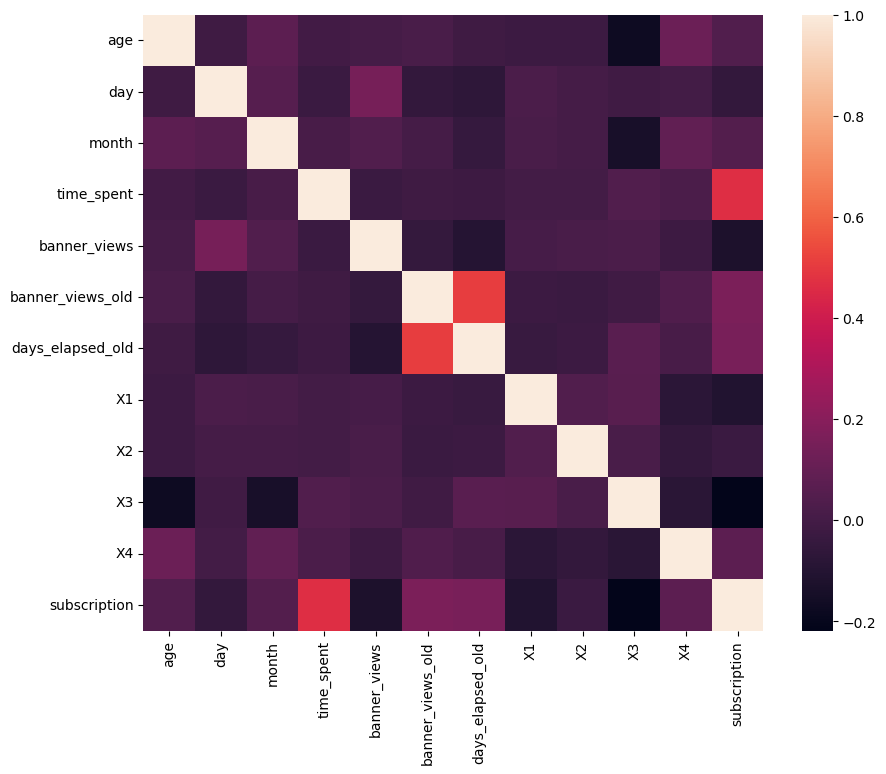

In [140]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 8))
all_numeric_columns = [col for col in descr if col != 'Id']
corr = train[all_numeric_columns].corr()
sns.heatmap(corr)

In [141]:
print(corr['banner_views_old']['days_elapsed_old'])

0.5057941040468478


In [142]:
print(corr['subscription']['time_spent'])

0.46569143735408963


As we can see, the subscription is highly correlated with time_spent. So, we expect this feature to be very important in our prediction.

<AxesSubplot:xlabel='banner_views_old', ylabel='time_spent'>

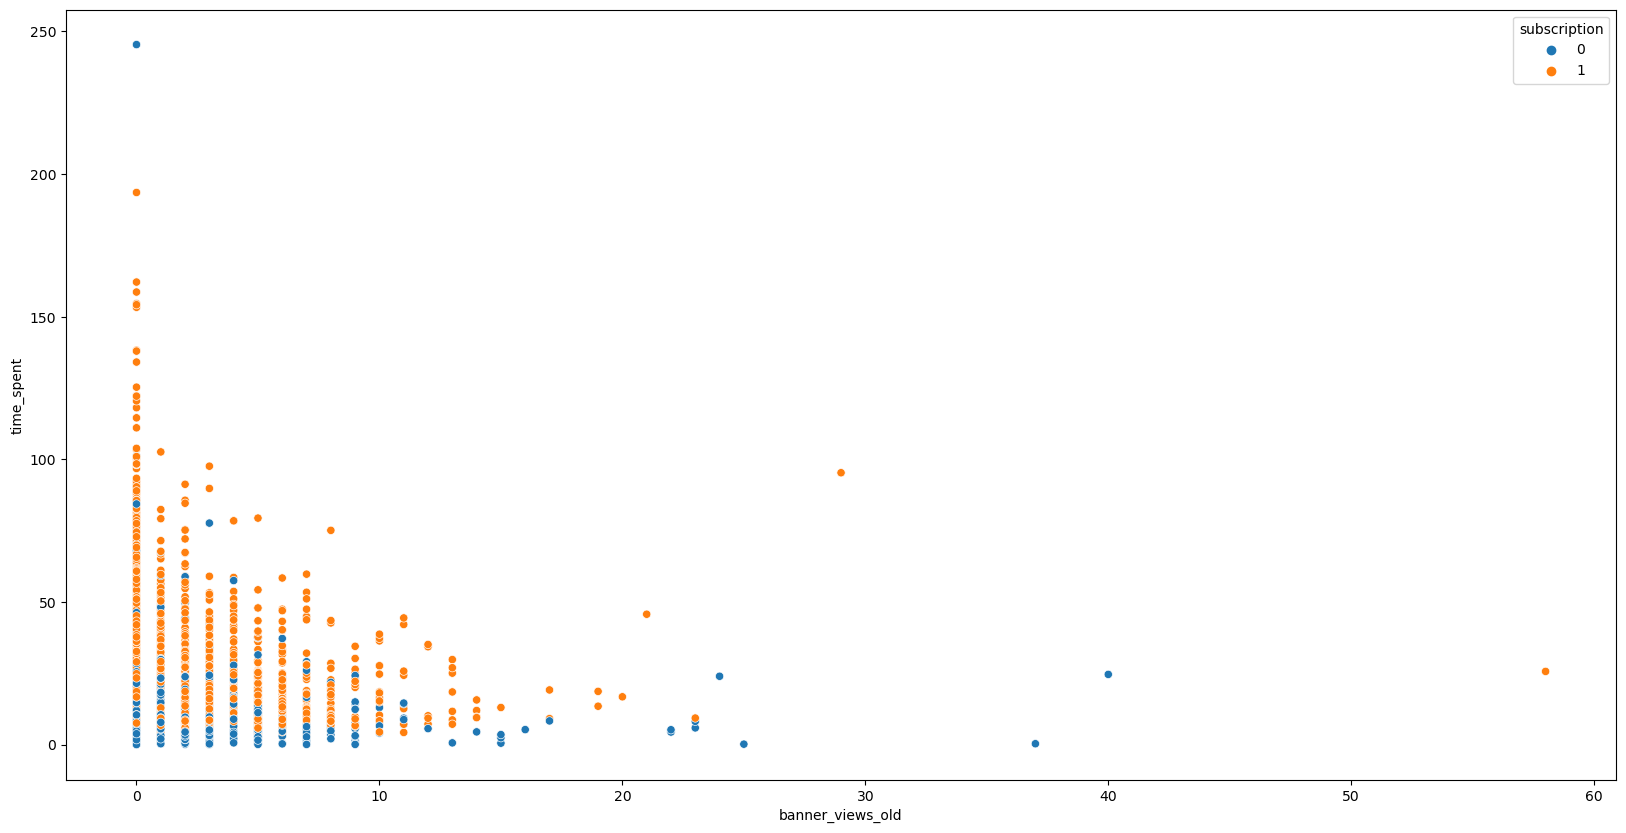

In [143]:
fig = plt.figure(figsize=(20, 10))
sns.scatterplot(
    data=train,
    x='banner_views_old',
    y='time_spent',
    hue='subscription',
)

According to the chart people with lower time_spent a less likely to buy subscription, that match the positive correlation between features.

Let's have a look on the categorical variables

In [144]:
categorical_columns = ['job', 'marital', 'education', 'device', 'outcome_old']
for column in categorical_columns:
    print(f'{column}: {train[column].unique()}')

job: ['freelance' 'industrial_worker' 'teacher' 'unemployed' 'manager'
 'salesman' 'technology' 'retired' 'student' 'housekeeper' 'entrepreneur'
 'na']
marital: ['married' 'divorced' 'single']
education: ['grad_school' 'university' 'high_school' 'na']
device: ['smartphone' 'na' 'desktop']
outcome_old: ['failure' 'success' 'na' 'other']


Let's analyse distributions of provided categorical variables

In [145]:
def encode_categorical_features(data):
    for col in categorical_columns:
        new_cols = pd.get_dummies(data[col])
        if 'na' in new_cols.columns:
            new_cols = new_cols.drop(columns=['na'])
        else:
            new_cols = new_cols[new_cols.columns[:-1]]
        columns = [f'{col}_{column}' for column in new_cols.columns]
        data[columns] = new_cols
    data.drop(columns=categorical_columns, inplace=True)

In [146]:
train[train['days_elapsed_old'] == -1]['days_elapsed_old'] = 365

/var/folders/g5/mjyfvtgx71q7y1zwphg8_xxc0000gn/T/ipykernel_62491/2035951598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[train['days_elapsed_old'] == -1]['days_elapsed_old'] = 365


## Model 1 : Random forest

In [147]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Preprocess data
encode_categorical_features(train)

# Separate features from labels
X_train = train.drop(columns=['subscription'])
y_train = train['subscription']

# Split the data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [148]:
# Initialize the random forest classifier
rf = RandomForestClassifier(random_state=42)

# Define a grid for the hyperparameter search
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform a grid search
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

# Retrieve the best model
best_rf = grid_search.best_estimator_

# Train and predict using the model with the best parameters
modelrf = RandomForestClassifier(**best_params)
modelrf.fit(X_train, y_train)

Best parameters:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


RandomForestClassifier(min_samples_leaf=2)

In [149]:
predict_test = modelrf.predict(X_test)
predict_train = modelrf.predict(X_train)

accuracy_train = round(accuracy_score(y_train, predict_train), 6)
accuracy_test = round(accuracy_score(y_test, predict_test), 6)
print(f'{accuracy_train=}\n{accuracy_test=}')

accuracy_train=0.973467
accuracy_test=0.850921


## Model 2 : XGboost

In [155]:
train = pd.read_csv('MLUnige2023_subscriptions_train.csv')
test = pd.read_csv('MLUnige2023_subscriptions_test.csv')

# Preprocess data
encode_categorical_features(train)

# Separate features from labels
X_train = train.drop(columns=['subscription'])
y_train = train['subscription']

# Split the data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [157]:
from xgboost import XGBClassifier
import xgboost as xgb

# Create a XGBClassifier model
model = XGBClassifier(
    objective='binary:logistic',  # this is for binary classification
)

# Define a grid for the hyperparameter search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [50, 100, 200, 500]
}

# Perform a grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the grid_search to the training data
grid_search.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [158]:
from sklearn.metrics import accuracy_score

predict_test = best_xgb.predict(X_test)
predict_train = best_xgb.predict(X_train)

accuracy_train = round(accuracy_score(y_train, predict_train), 3)
accuracy_test = round(accuracy_score(y_test, predict_test), 3)
print(f'{accuracy_train=}\n{accuracy_test=}')

accuracy_train=0.932
accuracy_test=0.861


## Model 3 : CatBoost

In [30]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
model = CatBoostClassifier()

test_size = 0.3
X = train.drop(columns=['Id', 'subscription'])
y = train['subscription']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=test_size
)

model.fit(X_train, y_train)

ModuleNotFoundError: No module named 'catboost'

In [235]:
X_train.columns

In [236]:
model.feature_importances_

In [237]:
predict_test = model.predict(X_test)
predict_train = model.predict(X_train)

In [238]:
from sklearn.metrics import accuracy_score

accuracy_train = round(accuracy_score(y_train, predict_train), 3)
accuracy_test = round(accuracy_score(y_test, predict_test), 3)
print(f'{accuracy_train=}\n{accuracy_test=}')

## Comparing the 3 models

## Generate a Kaggle submission

In [239]:
encode_categorical_features(test)

In [240]:
submission = test[['Id']]
submission['subscription'] = model.predict(test.drop(columns=['Id']))
submission.head()

In [241]:
len(submission)

In [ ]:
submission.to_csv('subission.csv', index=False)